# Plotting Covid-19 data from Belgium

Source of data: [RTBF](https://www.rtbf.be/info/societe/detail_coronavirus-en-belgique-les-chiffres-du-nombre-de-personnes-hospitalisees-infographie?id=10458755). Last update 26/03.

This is not (data) science, it's just a plot of some data and a linear regression.

License [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
%pylab inline
import pandas as pd
from datetime import date, timedelta

import matplotlib
matplotlib.rc('figure', figsize=(17, 5))

from scipy.optimize import curve_fit
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
start = date(2020, 3, 14)
df = pd.DataFrame([
    (97, 24, 22),
    (163, 33, 23),
    (252, 53, 31),
    (361, 79, 51),
    (496, 100, 66),
    (634, 130, 88),
    (837, 164, 114),
    (1089, 238, 167),
    (1380, 290, None),
    (1643, 322, None),
    (1859, 381, 242),
    (2152, 433, 322),
    (2652, 605, 420),
], columns=["hospit", "intensif", "respi"])

gvt_measures = [
    pd.to_datetime('2020-03-14'),  # Bars and non-essential shops closed
    pd.to_datetime('2020-03-17'),  # Lockdown
]

df['date'] = pd.Series(df.index).apply(lambda x: start + timedelta(days=x))
df['day'] = pd.Series(df.index) + 1
df = df.set_index("date")

In [3]:
df.head()

,hospit,intensif,respi,day
date,,,,
2020-03-14,97,24,22.0,1
2020-03-15,163,33,23.0,2
2020-03-16,252,53,31.0,3
2020-03-17,361,79,51.0,4
2020-03-18,496,100,66.0,5


## Plot the data, both on linear and log scales

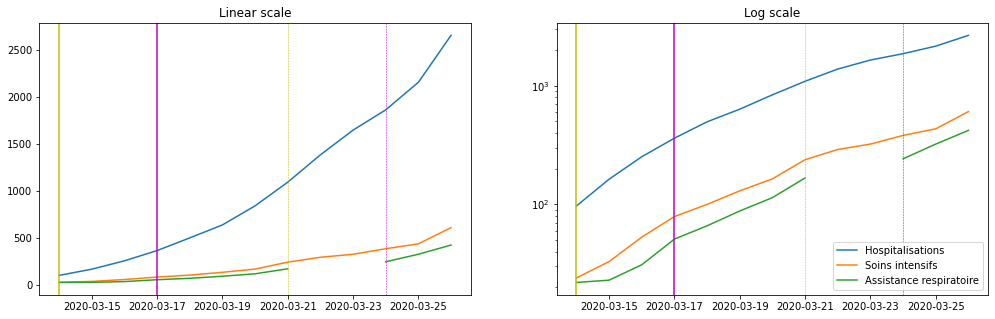

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax2.set_yscale('log')
ax1.set_title('Linear scale')
ax2.set_title('Log scale')

for ax in (ax1, ax2):
    ax.plot(df.index, df.hospit, label="Hospitalisations")
    ax.plot(df.index, df.intensif, label="Soins intensifs")
    ax.plot(df.index, df.respi, label="Assistance respiratoire")
    for t, c in zip(gvt_measures, 'ym'):
        ax.axvline(t, c=c)
        ax.axvline(t + pd.Timedelta('7d'), c=c, ls='--', lw=.5)

plt.legend();

## Linear regression on the log(data), aka exponential regression

In [5]:
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df.day, np.log(df.hospit))
hospit_pred = np.exp(intercept + slope* df.day)

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df.day, np.log(df.intensif))
intensif_pred = np.exp(intercept + slope* df.day)

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df.dropna().day, np.log(df.dropna().respi))
respi_pred = np.exp(intercept + slope* df.day)

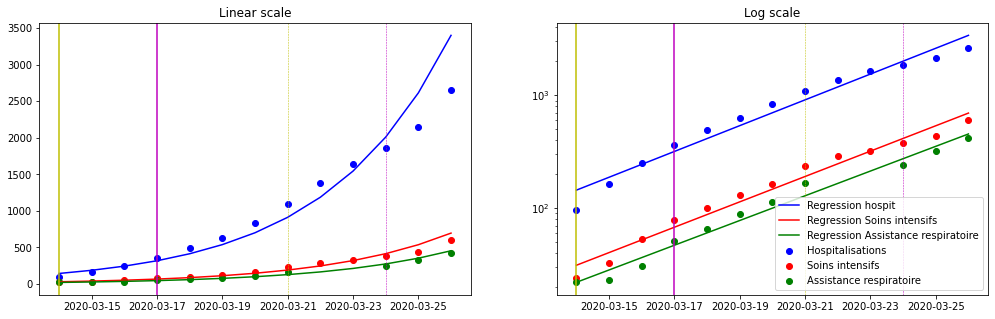

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax2.set_yscale('log')
ax1.set_title('Linear scale')
ax2.set_title('Log scale')

for ax in (ax1, ax2):
    ax.scatter(df.index, df.hospit, label="Hospitalisations", marker="o", color="b")
    ax.plot(df.index, hospit_pred, label="Regression hospit", color="b")

    ax.scatter(df.index, df.intensif, label="Soins intensifs", marker="o", color="r")
    ax.plot(df.index, intensif_pred, label="Regression Soins intensifs", color="r")

    ax.scatter(df.index, df.respi, label="Assistance respiratoire", marker="o", color="g")
    ax.plot(df.index, respi_pred, label="Regression Assistance respiratoire", color="g")

    for t, c in zip(gvt_measures, 'ym'):
        ax.axvline(t, c=c)
        ax.axvline(t + pd.Timedelta('7d'), c=c, ls='--', lw=.5)

plt.legend();

## Compute the regression on data [day0, dayN] for each N

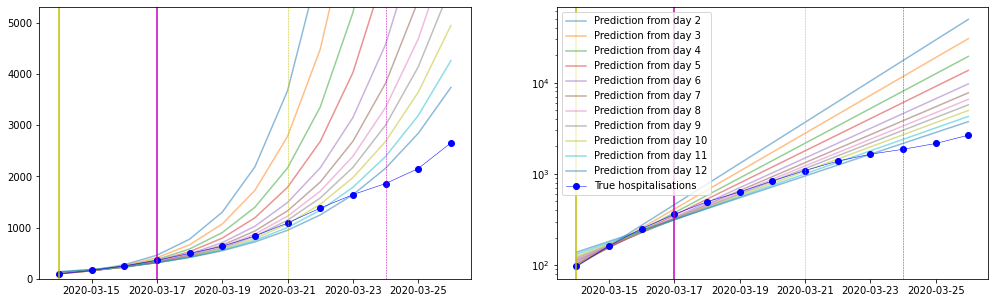

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax2.set_yscale('log')

for ax in (ax1, ax2):
    for i in range(2, len(df.day)):
        (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df.day[:i], np.log(df.hospit[:i]))
        hospit_pred = np.exp(intercept + slope* df.day)
        ax.plot(df.index, hospit_pred, label=f"Prediction from day {i}", alpha=0.5)


    ax.plot(df.index, df.hospit, label="True hospitalisations", marker="o", color="b", lw=.5)

    for t, c in zip(gvt_measures, 'ym'):
        ax.axvline(t, c=c)
        ax.axvline(t + pd.Timedelta('7d'), c=c, ls='--', lw=.5)

ax1.set_ylim(0, df.hospit.max() * 2)
plt.legend();

In [8]:
reg = pd.DataFrame(
    [
        stats.linregress(df.day[:i], np.log(df.hospit[:i]))
        for i in range(2, len(df.day))
    ],
    columns= ['slope', 'intercept', "rvalue", "pvalue", "stderr"]
)
reg['slopediff'] = reg.slope.diff()

In [9]:
reg

,slope,intercept,rvalue,pvalue,stderr,slopediff
0,0.519039,4.055672,1.000000,0.000000e+00,0.000000,NaN
1,0.477359,4.111245,0.998732,3.206537e-02,0.024064,-0.041680
2,0.437818,4.177147,0.996693,3.306597e-03,0.025238,-0.039541
3,0.405886,4.241012,0.995010,4.228698e-04,0.023499,-0.031932
4,0.373846,4.315771,0.991818,1.001390e-04,0.024059,-0.032040
5,0.352110,4.373733,0.991108,1.425032e-05,0.021140,-0.021736
6,0.335644,4.423133,0.991102,1.749681e-06,0.018403,-0.016467
7,0.321371,4.470708,0.990938,2.312440e-07,0.016465,-0.014272
8,0.306091,4.526736,0.989480,5.290714e-08,0.015822,-0.015280
9,0.289457,4.593270,0.986367,2.315335e-08,0.016097,-0.016634


In [10]:
reg.slope.diff()

0          NaN
1    -0.041680
2    -0.039541
3    -0.031932
4    -0.032040
5    -0.021736
6    -0.016467
7    -0.014272
8    -0.015280
9    -0.016634
10   -0.015100
Name: slope, dtype: float64